# Imputing Knowledge about Gene and Protein Function with Machine Learning

In [16]:
# Imports 
## Data processing
import pandas as pd
import numpy as np
## Machine Learning
import sklearn as sk
from sklearn import decomposition
from sklearn import ensemble
from sklearn import model_selection
from sklearn import pipeline
from sklearn import metrics
from sklearn import manifold
## Plotting
from matplotlib import pyplot as plt
## Harmonizome API
from harmonizome import Harmonizome
## Utility
import re
import json
from functools import reduce
from IPython.display import display

In [17]:
# Utility functions

## Early stopping function
def early_stopping(n_rounds, tol=0.001):
    def early_stopping_func(i, self, local):
        rounds = getattr(self, '__rounds', 0)
        last = getattr(self, '__last', None)
        current = self.train_score_[i]
        if last and current and abs(current - last) < tol:
            rounds += 1
            if rounds > n_rounds:
                return True
        else:
            rounds = 0
        setattr(self, '__last', current)
        setattr(self, '__rounds', rounds)
        return False
    return early_stopping_func

## Create custom "randfloat" that behaves like randint but for floats
from scipy.stats import uniform, randint
def randfloat(start, end):
    ''' Utility function for generating a float uniform distribution '''
    return uniform(start, end - start)

# reproducable random seed
rng = 2018

## Inputs

Given a target attribute of interest, we will use machine learning to predict genes that are strongly correlated with that target. Using the Harmonizome data query API, we download the dataset containing the target attribute as well as a number of well-populated Omics datasets for more genes and features and build a large sparse dataframe.

In [18]:
# attribute_datasets = {{ MultiChoiceField(
#                         name='attribute-databases',
#                         label='Attribute Selection',
#                         hint='Databases to use for prediction',
#                         default=[
#                             'CCLE Cell Line Gene Expression Profiles',
#                             'ENCODE Transcription Factor Targets',
#                         ],
#                         choices=[
#                             'CCLE Cell Line Gene Expression Profiles',
#                             'ENCODE Transcription Factor Targets',
#                             'Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles',
#                             'CHEA Transcription Factor Targets',
#                             'BioGPS Cell Line Gene Expression Profiles',
#                             'GTEx Tissue Gene Expression Profiles',
#                         ],
#                         group='Targets',
#                     ) }}
attribute_datasets = [
                            'CCLE Cell Line Gene Expression Profiles',
                            'ENCODE Transcription Factor Targets',
                        ]

# Download attribute datasets from Harmonizome
df_attributes = list(Harmonizome.download_df(
    [dataset
     for dataset in attribute_datasets],
    ['gene_attribute_matrix.txt.gz'],
))
for name, df in zip(attribute_datasets, df_attributes):
    df.index.name = json.loads(df.index.name)[0]
    df.index = df.index.map(lambda s: json.loads(s)[0])
    print('%s shape:' % (name), df.shape)
    display(df.head())

# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='inner', # Drop any mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]

X = df.applymap(lambda f: 1 if f==1 else 0)
print('Total Shape:', X.shape)
display(X.head())

CCLE Cell Line Gene Expression Profiles shape: (18025, 1037)


,"[""CHL1"", ""skin"", ""na""]","[""HMCB"", ""skin"", ""na""]","[""HS852T"", ""skin"", ""na""]","[""HS695T"", ""skin"", ""na""]","[""A101D"", ""skin"", ""na""]","[""HS294T"", ""skin"", ""na""]","[""SNU466"", ""central nervous system"", ""na""]","[""SKMEL31"", ""skin"", ""na""]","[""SKMEL24"", ""skin"", ""na""]","[""WM115"", ""skin"", ""na""]",...,"[""HEL9217"", ""haematopoietic and lymphoid tissue"", ""na""]","[""HEL"", ""haematopoietic and lymphoid tissue"", ""na""]","[""UT7"", ""haematopoietic and lymphoid tissue"", ""na""]","[""SET2"", ""haematopoietic and lymphoid tissue"", ""na""]","[""MOLM16"", ""haematopoietic and lymphoid tissue"", ""na""]","[""KU812"", ""haematopoietic and lymphoid tissue"", ""na""]","[""TF1"", ""haematopoietic and lymphoid tissue"", ""na""]","[""MEG01"", ""haematopoietic and lymphoid tissue"", ""na""]","[""KYO1"", ""haematopoietic and lymphoid tissue"", ""na""]","[""K562"", ""haematopoietic and lymphoid tissue"", ""na""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITGBL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LRP1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTBP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PARVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ENCODE Transcription Factor Targets shape: (22819, 181)


,"[""ARID3A"", ""na"", ""1820""]","[""ATF1"", ""na"", ""466""]","[""ATF2"", ""na"", ""1386""]","[""ATF3"", ""na"", ""467""]","[""BACH1"", ""na"", ""571""]","[""BATF"", ""na"", ""10538""]","[""BCL11A"", ""na"", ""53335""]","[""BCL3"", ""na"", ""602""]","[""BCLAF1"", ""na"", ""9774""]","[""BDP1"", ""na"", ""55814""]",...,"[""ZC3H11A"", ""na"", ""9877""]","[""ZEB1"", ""na"", ""6935""]","[""ZKSCAN1"", ""na"", ""7586""]","[""ZMIZ1"", ""na"", ""57178""]","[""ZNF143"", ""na"", ""7702""]","[""ZNF217"", ""na"", ""7764""]","[""ZNF263"", ""na"", ""10127""]","[""ZNF274"", ""na"", ""10782""]","[""ZNF384"", ""na"", ""171017""]","[""ZZZ3"", ""na"", ""26009""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
A1BG,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-AS1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN


Total Shape: (17480, 1218)


,"[""CHL1"", ""skin"", ""na""]","[""HMCB"", ""skin"", ""na""]","[""HS852T"", ""skin"", ""na""]","[""HS695T"", ""skin"", ""na""]","[""A101D"", ""skin"", ""na""]","[""HS294T"", ""skin"", ""na""]","[""SNU466"", ""central nervous system"", ""na""]","[""SKMEL31"", ""skin"", ""na""]","[""SKMEL24"", ""skin"", ""na""]","[""WM115"", ""skin"", ""na""]",...,"[""ZC3H11A"", ""na"", ""9877""]","[""ZEB1"", ""na"", ""6935""]","[""ZKSCAN1"", ""na"", ""7586""]","[""ZMIZ1"", ""na"", ""57178""]","[""ZNF143"", ""na"", ""7702""]","[""ZNF217"", ""na"", ""7764""]","[""ZNF263"", ""na"", ""10127""]","[""ZNF274"", ""na"", ""10782""]","[""ZNF384"", ""na"", ""171017""]","[""ZZZ3"", ""na"", ""26009""]"
GeneSym,,,,,,,,,,,,,,,,,,,,,
FBN1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
ITGBL1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
LRP1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,1,0,1,0,1,0
LTBP2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,1,0
PARVA,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [19]:
# target_class = "{{ TargetClassSearchField(
#                         name='target-class',
#                         label='Class Selection',
#                         hint='Class you want to predict',
#                         default='central nervous system (SNU466 from CCLE Cell Line Gene Expression Profiles)',
#                         examples=[
#                         ],
#                         group='Targets',
#                     ) }}"
target_class = "intracranial cystic lesion (Phenotype from HPO Gene-Disease Associations)"

# Separate target attribute and dataset
class_name, class_type, class_dataset = re.match(
    r'^(.+) \((.+) from (.+)\)$',
    target_class,
).groups()
target_class_col = class_name

# Download class datasets from Harmonizome
df_class = list(Harmonizome.download_df(
    [class_dataset],
    ['gene_attribute_matrix.txt.gz'],
))[0]
df_class.columns = df_class.columns.map(lambda s: json.loads(s)[0])
df_class.index.name = json.loads(df_class.index.name)[0]
df_class.index = df_class.index.map(lambda s: json.loads(s)[0])
print('%s shape:' % (class_dataset), df_class.shape)
display(df_class.head())

# Collect genes of interest
target_genes = df_class[df_class[target_class_col] == 1].index
print('Number of Target Genes:', len(target_genes))

HPO Gene-Disease Associations shape: (3158, 6842)


,severe t lymphocytopenia,failure to thrive secondary to recurrent infections,recurrent opportunistic infections,abnormality of b cell number,b lymphocytopenia,severe b lymphocytopenia,abnormality of the mastoid,mastoiditis,abnormal lymphocyte count,abnormality of t cell number,...,chronic calcifying pancreatitis,histiocytoma,honeycomb retinal degeneration,orthostatic tachycardia,alveolar soft part sarcoma,salmonella osteomyelitis,facial flushing after alcohol intake,delayed oxidation of acetaldehyde,membranous cataract,congenital ptosis
GeneSym,,,,,,,,,,,,,,,,,,,,,
CNGA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NEK2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CA4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GUCA1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of Target Genes: 92


In [20]:
# Create final target array
y = np.in1d(X.index, target_genes).astype(np.int8)
print('Known Target Genes: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))

# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Known Target Genes: 89 (0.509 %)
Input shape: (17480, 1218)
Target shape: (17480,)


## Dimensionality Reduction

We perform dimensionality reduction with sk.decomposition.{{ ChoiceField(name='dimensionality-reduction-algorithm', label='Dimensionality Reduction Algorithm', default='PCA', choices=['PCA', 'TruncatedSVD'], group='Algorithm') }}.

In [21]:
# dreduc = sk.decomposition.{{ dimensionality-reduction-algorithm }}(n_components=64)
clf_dimensionality_reduction = sk.decomposition.PCA(n_components=64)
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))

Explained variance: 26.336144125756867


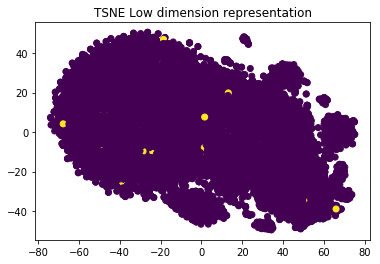

In [22]:
# Perform TSNE for low dimensional visualization

tsne = sk.manifold.TSNE(n_components=2, random_state=rng)
X_transformed_tsne = tsne.fit_transform(X_reduced, y)

# Plot results of PCA
plt.title('TSNE Low dimension representation')
plt.scatter(
    X_transformed_tsne[:, 0],
    X_transformed_tsne[:, 1],
    c=y,
)
plt.show()

## Algorithm

We will perform the analysis based on the selections made here.

In [8]:
# algorithm = sk.ensemble.{{ ChoiceField(name='algorithm', label='Machine Learning Algorithm', default='RandomForestClassifier', choices=['RandomForestClassifier', 'GradientBoostingClassifier'], group='Algorithm') }}
# hyper_param_search = sk.model_selection.{{ ChoiceField(name='hyper-param-search-type', label='Hyper Parameter Search Type', default='RandomizedSearchCV', choices=['RandomizedSearchCV', 'GridSearchCV'], group='Algorithm')}}
# n_folds = {{ IntField(name='cross-validation-n-folds', label='Number of Cross-Validated Folds', default=3, min=2, max=10, group='Algorithm') }}
# evaluation_metrics = sk.metrics.{{ MultiChoiceField(name='evaluation-metrics', label='Addition Metrics', default=[], choices=['auc'], group='Algorithm') }}
# primary_metric = sk.metrics.{{ ChoiceField(name='primary-metric', label='Primary metric', default='log_loss', choices=['log_loss'], group='Algorithm') }}

dimensionality_reduction_algorithm = sk.decomposition.TruncatedSVD
algorithm = sk.ensemble.GradientBoostingClassifier
# algorithm = sk.ensemble.RandomForestClassifier
hyper_param_search = sk.model_selection.RandomizedSearchCV
n_folds = 3
evaluation_metrics = ['auc']
primary_metric = 'log_loss'
cv_algorithm = sk.model_selection.StratifiedKFold
n_iter = 1

# evaluation_metrics 'explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'median_absolute_error', 'mean_absolute_error', 'mean_squared_error', 'accuracy', 'average_precision', 'log_loss', 'neg_log_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 

In [9]:
pipe = sk.pipeline.Pipeline([
    # Reduce dimensionality by applying TruncatedSVD
#     ('reduce_dim', {{ dimensionality-reduction-algorithm }}),
    ('reduce_dim', dimensionality_reduction_algorithm()),
    # Classify with gradient boosting
    ('clf', algorithm()),
])

cv = cv_algorithm(
    n_splits=n_folds,
    shuffle=True,
    random_state=rng,
)

param_grid = {
    'reduce_dim__n_components': randint(2, 1024),
    # {% if algorithm == 'GradientBoostingClassifier' %}
    'clf__loss': ['deviance', 'exponential'],
    'clf__learning_rate': randfloat(0.001, 1.),
    'clf__subsample': randfloat(0.01, 1.),
    # {% elif algorithm == 'RandomForestClassifier' %}
#     'clf__oob_score': [True],
#     'clf__criterion': ['gini', 'entropy'],
#     {% endif %}
    'clf__n_estimators': randint(10, 200),
    'clf__max_depth': randint(20, 50),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_impurity_decrease': randfloat(0., 0.2),
    'clf__min_weight_fraction_leaf': randfloat(0., 0.5),
    # {% endif %}
}

# Fit parameters
fit_params = {
    #{% if algorithm == 'GradientBoostingClassifier' %}
#     'clf__monitor': early_stopping(5),
    #{% endif %}
}

# Scoring parameters
scoring_params = {k: v
                  for k,v in metrics.scorer.SCORERS.items()
                  if k == primary_metric or k in evaluation_metrics}

# Params to pass to search
search_params = {
    'cv': cv,
    'refit': primary_metric,
    'verbose': 10,
    'random_state': rng,
    'scoring': {k: v
                for k,v in scoring_params.items()
                if k == primary_metric or k in evaluation_metrics},
    'return_train_score': True,
    'n_iter': n_iter,
}

search = hyper_param_search(
    pipe,
    param_grid,
    **search_params,
)


This will take a long time as we are evaluating n_iter different models n_splits different times each computing all the metrics on `product(X.shape)` data points--not to mention the size of each model dictated by the range of parameters specified in the params dict.

In [10]:
# Evaluate pipeline
search.fit(X.values, y, **fit_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__learning_rate=0.882466962442192, clf__loss=deviance, clf__max_depth=29, clf__max_features=log2, clf__min_impurity_decrease=0.0038714949882014075, clf__min_weight_fraction_leaf=0.016323433989319458, clf__n_estimators=163, clf__subsample=0.5940855376083128, reduce_dim__n_components=433 


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  clf__learning_rate=0.882466962442192, clf__loss=deviance, clf__max_depth=29, clf__max_features=log2, clf__min_impurity_decrease=0.0038714949882014075, clf__min_weight_fraction_leaf=0.016323433989319458, clf__n_estimators=163, clf__subsample=0.5940855376083128, reduce_dim__n_components=433, log_loss=-0.08658496807299518, total=   5.7s
[CV] clf__learning_rate=0.882466962442192, clf__loss=deviance, clf__max_depth=29, clf__max_features=log2, clf__min_impurity_decrease=0.0038714949882014075, clf__min_weight_fraction_leaf=0.016323433989319458, clf__n_estimators=163, clf__subsample=0.5940855376083128, reduce_dim__n_components=433 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  clf__learning_rate=0.882466962442192, clf__loss=deviance, clf__max_depth=29, clf__max_features=log2, clf__min_impurity_decrease=0.0038714949882014075, clf__min_weight_fraction_leaf=0.016323433989319458, clf__n_estimators=163, clf__subsample=0.5940855376083128, reduce_dim__n_components=433, log_loss=-0.11313778651274607, total=   5.3s
[CV] clf__learning_rate=0.882466962442192, clf__loss=deviance, clf__max_depth=29, clf__max_features=log2, clf__min_impurity_decrease=0.0038714949882014075, clf__min_weight_fraction_leaf=0.016323433989319458, clf__n_estimators=163, clf__subsample=0.5940855376083128, reduce_dim__n_components=433 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  clf__learning_rate=0.882466962442192, clf__loss=deviance, clf__max_depth=29, clf__max_features=log2, clf__min_impurity_decrease=0.0038714949882014075, clf__min_weight_fraction_leaf=0.016323433989319458, clf__n_estimators=163, clf__subsample=0.5940855376083128, reduce_dim__n_components=433, log_loss=-3.0649755228576767, total=   8.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.4s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2018, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('reduce_dim', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_n...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'reduce_dim__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10fb0f470>, 'clf__loss': ['deviance', 'exponential'], 'clf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10fb0f5f8>, 'clf__subsample': <scipy.stats._distn_infrastruct...clf__min_weight_fraction_leaf': <scipy.stats._distn_infrastruc

In [11]:
# Display training results
if n_iter > 1:
    for metric in [primary_metric]+evaluation_metrics:
        df_met = pd.DataFrame.from_dict({
            'mean_test_%s' % (metric): search.cv_results_['mean_test_%s' % (metric)],
            'mean_train_%s' % (metric): search.cv_results_['mean_train_%s' % (metric)],
        }).sort_values('mean_test_%s' % (metric), ascending=False)
        df_met.plot(use_index=False)
        plt.title('Mean %s' % (metric))
        plt.show()

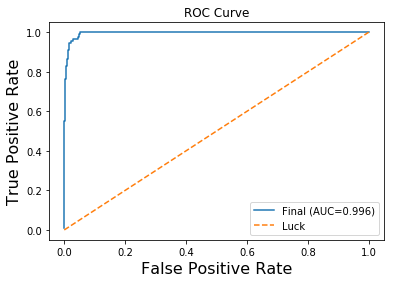

In [12]:
# Calculate final ROC curve
y_probas = search.predict_proba(X.values)
fpr, tpr, _ = sk.metrics.roc_curve(y, y_probas[:, 1])
score = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='Final (AUC=%.3f)' % (score))
# Annotate chart
plt.plot([0, 1], [0, 1], '--', label='Luck')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right')
plt.show()

In [27]:
import seaborn

array([[17385,     6],
       [   43,    46]])

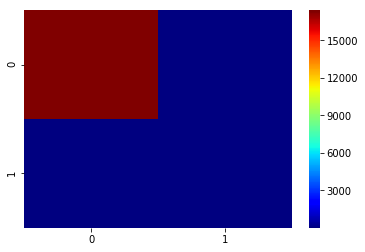


 True labels predicted to be true: 17385 
 True labels predicted to be false: 6 
 False labels predicted to be true: 43 
 False labels predicted to be false: 46


In [32]:
cm = metrics.confusion_matrix(y, search.predict(X.values))
plt.show()
print('\n',
    'True labels predicted to be true:', cm[0,0], '\n',
    'True labels predicted to be false:', cm[0,1], '\n',
    'False labels predicted to be true:', cm[1,0], '\n',
    'False labels predicted to be false:', cm[1,1])

In [14]:
# Obtain prediction results
y_preds = search.predict(X)
y_probas = search.predict_proba(X)[:, 1]
results = pd.DataFrame(np.array([
    y,
    y_preds,
    y_probas,
]).T, columns=[
    'Known',
    'Predicted',
    'Prediction Probability',
], index=X.index)
results[(results['Prediction Probability'] > 0.5)]

,Known,Predicted,Prediction Probability
GeneSym,,,
GLI3,1.0,1.0,0.985855
GPC4,1.0,1.0,0.670972
TCTN2,1.0,1.0,0.919097
C8orf48,0.0,1.0,0.618654
AP1S2,1.0,1.0,0.765236
PIEZO2,1.0,1.0,0.917560
HRAS,1.0,1.0,0.689090
B9D1,1.0,1.0,0.973332
TMEM5,1.0,1.0,0.947925
